# Traffic Light Detection On Oriented Imagery Using Pre-Trained Model

> * 🔬 Data Science
> * 🥠 Deep Learning and Object classification

## Table of Contents
* [Introduction](#Introduction)
* [Necessary imports](#Necessary-imports)
* [Download & setting up data](#Download-&-setting-up-data)
* [Load model architecture](#Load-model-architecture)
* [Model inference](#Model-inference)
* [Results](#Results)
* [Conclusion](#Conclusion)

## Introduction

In this sample notebook we will be using `ArcGIS API for Python` for using a pre-trained deep learning model for object detection on oriented imagery data.  
We will be using the pre-trained YOLO model which is trained on [COCO dataset](https://cocodataset.org/#home) which is a publicly available large-scale object detection, segmentation, and captioning dataset.
This dataset has 1000 classes out of which one class is <b>traffic light</b>. Using this model we will try to detect traffic lights in the oriented imagery.

## Necessary imports

In [2]:
import os, json, cv2
from arcgis import GIS
from arcgis.mapping import WebMap
import zipfile
from pathlib import Path
from arcgis.learn import (
    prepare_data,
    YOLOv3,
)

## Download & setting up data

We will need oriented imagery so that we can use that for inferecing. We have sample images uploaded on [Python API Playground](https://pythonapi.playground.esri.com/portal). We will download those images below and use those for inferecing.

In [6]:
gis = GIS(
    "https://pythonapi.playground.esri.com/portal",
    "arcgis_python",
    "amazing_arcgis_123",
)

<IPython.core.display.Javascript object>

In [7]:
oriented_imagery_data = gis.content.get("1e87bd29443b49e78d0c94ec949849d0")
oriented_imagery_data

<Item title:"oriented_imagery_sample_data" type:Image Collection owner:arcgis_python>

<IPython.core.display.Javascript object>

In [ ]:
filepath = oriented_imagery_data.download(file_name=oriented_imagery_data.name)

In [ ]:
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

In [9]:
data_path = Path(os.path.join(os.path.splitext(filepath)[0]), "street_view_data")

<IPython.core.display.Javascript object>

## Load model architecture

Since we will be using the pre-trained YOLO model so we will pass `pretrained_backbone` as `True`. In this way while initiaizing the YOLO model the pre trained weights of the YOLO model with COCO dataset will be downloaded. We will later using these weights to detect traffic lights.

In [ ]:
yolo = YOLOv3(pretrained_backbone=True)

## Model inference

Once we have the model loaded and ready for inferencing we will be create a function named `traffic_light_finder` that will take orineted image as input and will return 2 things. 
- Json containing traffic lights coordinates
- Traffic lights annotated image

We will save all the Traffic lights annotated image into a folder and save all the annotations in a combined json file on the disk.

In [11]:
def traffic_light_finder(oriented_image_path):
    flag = 0
    coordlist = []
    temp_list = {}
    out = yolo.predict(oriented_image_path, threshold=0.5)
    test_img = cv2.imread(oriented_image_path)
    if len(out[0]) == 0:
        temp_list["object"] = False
    else:
        for index, (value, label, confidence) in enumerate(zip(out[0], out[1], out[2])):
            if label == "traffic light":
                flag = 1
                coordlist.append(
                    [int(value[0]), int(value[1]), int(value[2]), int(value[3])]
                )
                test_img = cv2.rectangle(
                    test_img,
                    (int(value[0]), int(value[1]), int(value[2]), int(value[3])),
                    (0, 0, 255),
                    10,
                )
                textvalue = label + "_" + str(confidence)
                cv2.putText(
                    test_img,
                    textvalue,
                    (int(value[0]), int(value[1]) - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1.5,
                    (0, 0, 255),
                    2,
                )
        if flag == 1:
            temp_list["object"] = True
            temp_list["coords"] = coordlist
            temp_list["assetname"] = "traffic light"
    return temp_list, test_img

<IPython.core.display.Javascript object>

Here we will create a folder named <b>traffic_light_marked</b> which will contain all the images with traffic lights detected on them. We can use these images to check the output of the model. Later we can use them for our use case.

In [ ]:
marked_image_saved_folder = os.path.join(os.getcwd(), "traffic_light_marked")
os.makedirs(marked_image_saved_folder, exist_ok=True)
marked_image_saved_folder

In [ ]:
data_list = {}
for e, image in enumerate(os.listdir(data_path)):
    try:
        val_dict, out_image = traffic_light_finder(os.path.join(data_path, image))
        if bool(val_dict):
            data_list[image] = val_dict
            cv2.imwrite(os.path.join(marked_image_saved_folder, image), out_image)
    except Exception as e:
        print(e)

Here we are also saving the coordinates of the traffic lights in a json file. We can use these coordinates to create a webmap or in any of the other use cases.

In [14]:
with open("traffic_light_data_sample.json", "w") as f:
    json.dump(data_list, f)

<IPython.core.display.Javascript object>

## Results 

Below are some of the images showcasing how the pre-trained YOLO model performs on the oriented imagery. 

<img src="../../static/img/oriented_image.gif" width="750" align="center">

In [15]:
gis2 = GIS("https://ivt.maps.arcgis.com")
search_result = gis2.content.search(
    "title:ViliniusOrientedImageryAISample", item_type="Web Map"
)
webmap_item = search_result[0]
webmap_item

<Item title:"ViliniusOrientedImageryAISample" type:Web Map owner:vinay_ivt>

<IPython.core.display.Javascript object>

In [ ]:
map1 = WebMap(webmap_item)
map1

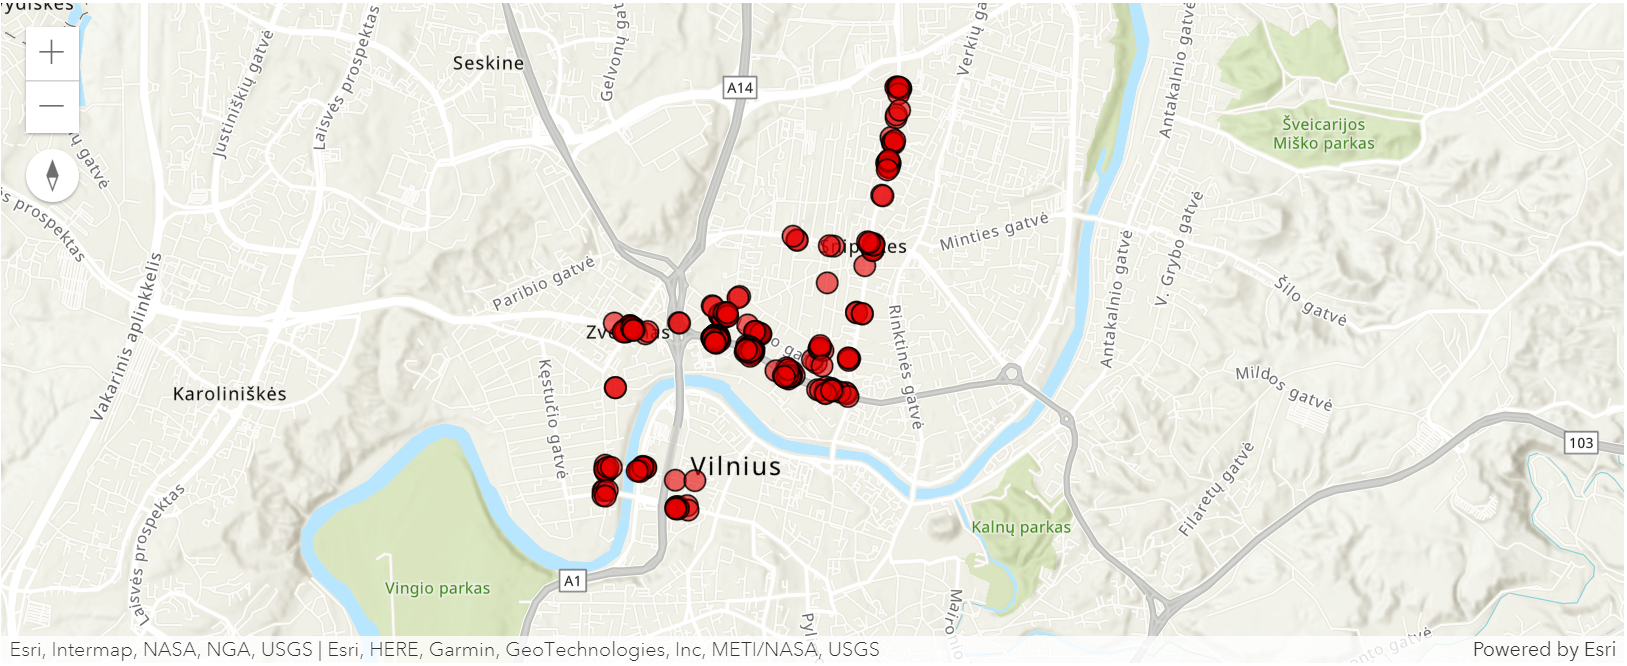

## Conclusion 

In this notebook, we demonstrated how to use Oriented Imagery for deep learning workflow using `ArcGIS API for Python`.